# Group Project: Machine Learning 

- <a href='#part1'>Part 1: Deep L-Layer Neural Network for Image Classification</a>
	- You will use pre-built functions to build an L-Layer neural network for an image classification task
- <a href='#part2'>Part 2: Full Machine Learning Project</a>
	- You will go through the full "idea, code, experiment" cycle to build and improve a model of your choice

You may work in groups of 1-3 students for this project.

In this project, especially in Part 2, you are expected to show the work you have done in the form of including results for models you have experimented with on the path to the best-performing model. Make sure you include Python and markdown boxes explaining and discussing any decisions you have made and interpretations of the results you have achieved. You can include diagrams, tables, and/or graphs using markdown. **A significant portion of your grade will be based on the progression of your model, not just the final result.**

**Note**: All work you submit must be the work of your group. Projects will be checked against each other, and against any work submitted in previous semesters where a similar project was given.

<a id="part1"></a>
## Part 1: Deep L-Layer Neural Network for Image Classification

You will use the functions given to you to build a deep L-layer network, and apply it to cat vs non-cat classification. Hopefully, you will see an improvement in accuracy relative to your previous logistic regression implementation.  

### 1.1 - Packages

Let's first import all the packages that you will need during this assignment. 
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](https://pillow.readthedocs.io/en/stable/index.html) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.
- nn_functions provides the functions you need to build an L-layer network.
- np.random.seed(1) is used to keep all the random function calls consistent. It will help us grade your work.

In [2]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow import keras
from nn_functions import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1.2 - Dataset

You will use the same "Cat vs non-Cat" dataset as in your previous assignment. The model you had built had 70% test accuracy on classifying cats vs non-cats images. Hopefully, your new model will perform a better!

**Problem Statement**: You are given a dataset containing:
- a training set of m_train images labelled as cat (1) or non-cat (0)
- a test set of m_test images labelled as cat and non-cat
- each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

Let's get more familiar with the dataset. Load the data by running the cell below.

In [65]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()
print(train_y.shape)

(1, 209)


The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 0. It's a non-cat picture.


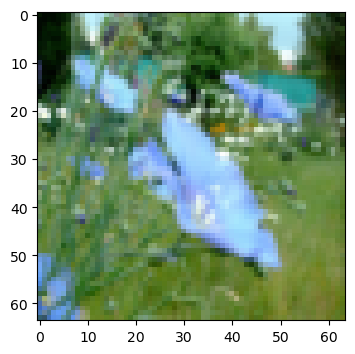

In [66]:
# Example of a picture
index = 20
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [67]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

In [68]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T
         
# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


$12,288$ equals $64 \times 64 \times 3$ which is the size of one reshaped image vector.

### 1.3 - Architecture of your model

Now that you are familiar with the dataset, it is time to build a deep neural network to distinguish cat images from non-cat images.

Here is a simplified network representation for an L-layer neural network:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 2</u>: L-layer neural network.</center></caption> 

The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 2</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

<u>General methodology</u>

As usual you will follow the Deep Learning methodology to build the model:
1. Initialize parameters / Define hyperparameters
2. Loop for num_iterations:
    - Forward propagation
    - Compute cost function
    - Backward propagation
    - Update parameters (using parameters, and grads from backprop) 
4. Use trained parameters to predict labels

In [14]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [15]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    parameters = initialize_parameters_deep(layers_dims)
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # START CODE HERE ### (≈ 4 lines of code)
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        # Compute cost.
        cost =compute_cost(AL, Y)
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

You will now train the model as a 4-layer neural network. 

Run the cell below to train your model. The cost should decrease on every iteration. It may take a few minutes to run 2500 iterations. 

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


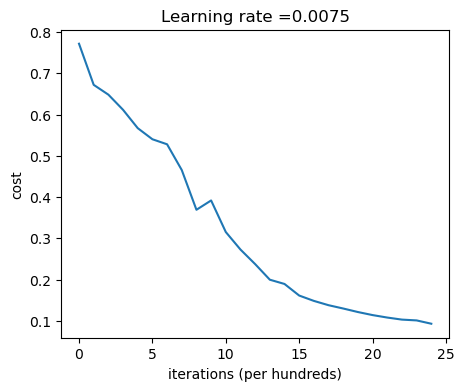

In [16]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [17]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


In [18]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


Congratulations! It seems that your 4-layer neural network has better performance than your previous assignment network on the same test set. 

This is good performance for this task.

###  1.5 - Results Analysis

First, let's take a look at some images the L-layer model labeled incorrectly. This will show a few mislabeled images. 

[[1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0
  0 1 0 0 1 1 1 0 0 0 1 1 1 0]]


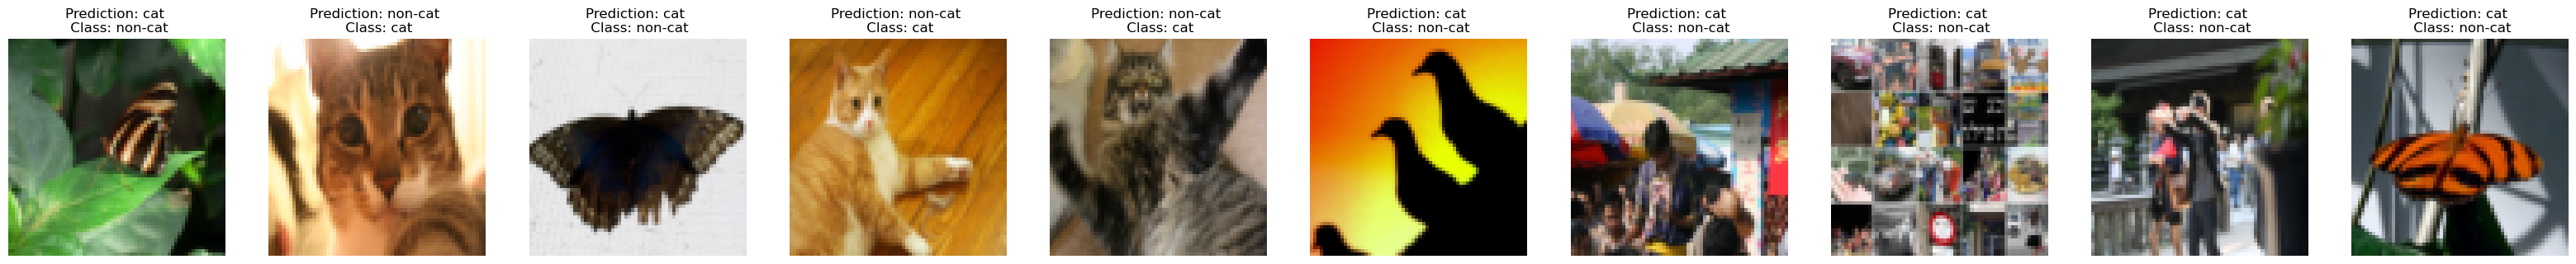

In [21]:
print_mislabeled_images(classes, test_x, test_y, pred_test)


**A few types of images the model tends to do poorly on include:** 
- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness of the picture
- Scale variation (cat is very large or small in image) 

### 1.6 - Test with your own image (optional/ungraded exercise) ##

You can use your own image and see the output of your model. To do that:
1. Add your image to the "images" folder
2. Change your image's name in the following code
3. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

In [ ]:
## START CODE HERE ##
my_image = "my_image.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = "images/" + my_image
image = Image.open(fname)
my_image = np.array(image.resize((num_px, num_px))).reshape((1, num_px*num_px*3)).T
my_image = my_image/255.

my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

<a id="part2"></a>
## Part 2: Full Machine Learning Project

Now you will use all you know about building and training neural networks in an "idea, code, experiment" cycle on a data set.

### 2.1 - Find a dataset (or datasets)

Find an appropriate dataset to work with. Some places to look:
- [Kaggle](https://www.kaggle.com/datasets) 
- [University of California, Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php)

You can choose just one, or more than one if you'd like to. Think carefully of the type of task you are trying to accomplish (e.g., classification, regression, etc.). Spend some time analyzing and processing the data. For example, decide how to split the data; should you have separate train, dev, and test sets? Does the data need to be cleaned or adjusted? How should the data be normalized? Any other considerations or adjustments needed for the data?

Clearly indicate where you found the dataset(s) you are working with.

Show the work you have done analyzing and processing the data in Python boxes in this notebook. There should also be associated markdown boxes discussing what you have observed and what decisions you have made.




I found two datasets on Kaggle: "Big Cats Image Classification Dataset" and "10 Big Cats of the Wild - Image Classification". I only used images of the snow/clouded leopard, tiger, lion, and cheetah from the "10 Big Cats of the Wild - Image Classification" dataset, which I combined with the "Big Cats Image Classification Dataset" to create a larger dataset for my model.

To make the dataset accessible and efficient, I wrote the images to a .h5 file and divided them into training and test sets, with 90% of images in the training set and 10% in the test set. However, I encountered some issues with the dataset, including .jpeg files and duplicate image names. I cleaned and adjusted the data to ensure every image had a unique name within its folder.

To make the images easier for the model to study, I resized all images to the same dimensions (225 x 225) and converted them to np arrays before writing them to their respective .h5 files. The images were labeled using the keys ..._set_x and ..._set_y in the .h5 files, with the latter corresponding to the correct classification of each image.

As I wanted as much data as possible for the training set, I decided to use the same dataset for both the development and train sets.

After I had filtered dataset and decided how I wanted to tranfrom it and what I wanted it to transfrom to, wrote the following to transfrom the data, but then I ran into some problem with my laptop, for some reason my laptop was giving .DStore file for some of the files so I decided to put in a if statment in place so that I only transform images and nothing else, also just as a caution I decided add an RGB coverter for images that might be damaged for some reason.

Also as a caution I made sure to truncate the data for test and train when I read it form the .h5 files, I did to make sure that I there wasnt any all 0 arrays that were still left in the dataset, so that model didnt have anytime of corrupted data to train or get tested with. 

In [4]:
# Your work for analyzing and processing the data
import os
import h5py
import numpy as np
from PIL import Image, ImageOps

img_size = (225, 225)
train_size = 0.90
test_size = 0.1

# shuffle the list of image file names
cheetah_files = []
leopard_files = []
lion_files = []
tiger_files = []

for file_name in os.listdir('animals'):
    animal_path = os.path.join('animals', file_name)
    if os.path.isdir(animal_path):
        if file_name == 'cheetah':
            cheetah_files += os.listdir(animal_path)
        elif file_name == 'leopard':
            leopard_files += os.listdir(animal_path)
        elif file_name == 'lion':
            lion_files += os.listdir(animal_path)
        elif file_name == 'tiger':
            tiger_files += os.listdir(animal_path)

image_files = cheetah_files + leopard_files + lion_files + tiger_files

# split the shuffled list of image file names into train and test sets
train_files = image_files[:int(len(image_files) * train_size)]
test_files = image_files[int(len(image_files) * test_size):]

# create the train and test datasets
train_dataset = h5py.File('trainanimals.h5', 'w')
test_dataset = h5py.File('testanimals.h5', 'w')

# create the dataset arrays for the train set
trainsetx_orig = train_dataset.create_dataset('train_set_x', (len(train_files), img_size[0], img_size[1],3), dtype='u1')
trainsety_orig = train_dataset.create_dataset('train_set_y', (len(train_files), 4), dtype='i')

# create the dataset arrays for the test set
testsetx_orig = test_dataset.create_dataset('test_set_x', (len(test_files), img_size[0], img_size[1],3), dtype='u1')
testsety_orig = test_dataset.create_dataset('test_set_y', (len(test_files), 4), dtype='i')
#animals_folders = ['cheetah', 'leopard', 'lion', 'tiger']
train_index =0
test_index =0

# get a list of all the image file names
cheetah_files = []
leopard_files = []
lion_files = []
tiger_files = []
for dic_name in os.listdir('animals'):
    animal_path = os.path.join('animals', dic_name)
    
    if os.path.isdir(animal_path):
        if dic_name == 'cheetah':
            i =0
            cheetah_files += os.listdir(animal_path)
            # loop through the images in each animal folder
            
            for j, file_name in enumerate(cheetah_files):
                 if not file_name.startswith('.'):
                    # load the image
                    image_path = os.path.join(animal_path, file_name)
                    image = Image.open(image_path)
                    if image.mode != 'RGB':
                        image = image.convert('RGB')
                    
                    # resize the image to img_size and maintain aspect ratio
                    image = ImageOps.fit(image, img_size, Image.ANTIALIAS)

                    # convert the image to a numpy array
                    image_data = np.array(image)
                    
                    if(image_data.shape == (img_size[0], img_size[1],3)):
                        if j < ((len(cheetah_files)) * train_size)-1:
                            trainsetx_orig[train_index] = image_data
                            trainsety_orig[train_index] = [1, 0, 0, 0]
                            
                            train_index += 1
                        else:
                            testsetx_orig[test_index] = image_data
                            testsety_orig[test_index] = [1, 0, 0, 0]
                            
                            test_index += 1
        elif dic_name == 'leopard':
            i=1
            leopard_files += os.listdir(animal_path)
            # loop through the images in each animal folder
            for j, file_name in enumerate(leopard_files):
                 if not file_name.startswith('.'):
                    # load the image
                    image_path = os.path.join(animal_path, file_name)
                    image = Image.open(image_path)
                    if image.mode != 'RGB':
                        image = image.convert('RGB')

                    # resize the image to img_size and maintain aspect ratio
                    image = ImageOps.fit(image, img_size, Image.ANTIALIAS)

                    # convert the image to a numpy array
                    image_data = np.array(image)
                    
                    if(image_data.shape == (img_size[0], img_size[1],3)):
                        if j < ((len(leopard_files)) * train_size)-1:
                            trainsetx_orig[train_index] = image_data
                            trainsety_orig[train_index] = [0, 1, 0, 0]
                            
                            train_index += 1
                        else:
                            testsetx_orig[test_index] = image_data
                            testsety_orig[test_index] = [0, 1, 0, 0]
                            
                            test_index += 1
        elif dic_name == 'lion':
            i = 2
            lion_files += os.listdir(animal_path)
            # loop through the images in each animal folder
            for j, file_name in enumerate(lion_files):
                 if not file_name.startswith('.'):
                    # load the image
                    image_path = os.path.join(animal_path, file_name)
                    image = Image.open(image_path)
                    if image.mode != 'RGB':
                        image = image.convert('RGB')
                    # resize the image to img_size and maintain aspect ratio
                    image = ImageOps.fit(image, img_size, Image.ANTIALIAS)

                    # convert the image to a numpy array
                    image_data = np.array(image)
                    
                    # add the image to the appropriate dataset
                    if(image_data.shape == (img_size[0], img_size[1],3)):
                        if j < ((len(lion_files)) * train_size)-1:
                            trainsetx_orig[train_index] = image_data
                            trainsety_orig[train_index] = [0, 0, 1, 0]
                            
                            train_index += 1
                        else:
                            testsetx_orig[test_index] = image_data
                            testsety_orig[test_index] = [0, 0, 1, 0]
                            
                            test_index += 1
        elif dic_name == 'tiger':
            i = 3
            tiger_files += os.listdir(animal_path)
            # loop through the images in each animal folder
            for j, file_name in enumerate(tiger_files):
                 if not file_name.startswith('.'):
                    # load the image
                    image_path = os.path.join(animal_path, file_name)
                    image = Image.open(image_path)
                    if image.mode != 'RGB':
                        image = image.convert('RGB')
                    # resize the image to img_size and maintain aspect ratio
                    image = ImageOps.fit(image, img_size, Image.ANTIALIAS)

                    # convert the image to a numpy array
                    image_data = np.array(image)
                    
                    # add the image to the appropriate dataset
                    if(image_data.shape == (img_size[0], img_size[1],3)):
                        if j < ((len(tiger_files)) * train_size)-1:
                            trainsetx_orig[train_index] = image_data
                            trainsety_orig[train_index] = [0, 0, 0, 1]
                            
                            train_index += 1
                        else:
                            testsetx_orig[test_index] = image_data
                            testsety_orig[test_index] = [0, 0, 0, 1]
                            
                            test_index += 1
        



classes = np.array([b'cheetah', b'leopard', b'lion', b'tiger'])
test_dataset.create_dataset('list_classes', data=classes)
train_dataset.create_dataset('list_classes', data=classes)



train_dataset.close()
test_dataset.close()



/var/folders/y6/d_2zty9916g6l__ph9v8ky7w0000gn/T/ipykernel_27338/3947331783.py:102: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = ImageOps.fit(image, img_size, Image.ANTIALIAS)
/var/folders/y6/d_2zty9916g6l__ph9v8ky7w0000gn/T/ipykernel_27338/3947331783.py:159: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = ImageOps.fit(image, img_size, Image.ANTIALIAS)
/var/folders/y6/d_2zty9916g6l__ph9v8ky7w0000gn/T/ipykernel_27338/3947331783.py:73: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = ImageOps.fit(image, img_size, Image.ANTIALIAS)
/var/folders/y6/d_2zty9916g6l__ph9v8ky7w0000gn/T/ipykernel_27338/3947331783.py:130: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). U

# 2.2 - Build your model

Start with a basic model, show the results, and then apply whichever improvements you decide to incorporate as per below.

You have two options for building your model:
- **The difficult option**: Use the provided L-layer network code used above in Part 1 and (later) extend it to incorporate more advanced neural network improvements as given in class
- **The easier option**: Use [Keras](https://keras.io) and [TensorFlow](https://www.tensorflow.org) to build a network
	- You may *not* use any framework other than Keras/TensorFlow

Ambition will be rewarded! If you choose the easier option, you are expected to incorporate more of the potential improvements given below.

Some of the neural network improvements you can consider incorporating for either option (not an exhaustive list):
- Weight initialization methods (e.g., zeroes, random, etc.)
- Regularization: L2, dropout, etc.
- Mini-batch gradient descent
- Gradient descent optimization algorithm: momentum, RMSProp, Adam, etc.
- Batch normalization

Show the results with your model with improvements. Use markdown boxes to discuss the effect of your improvement(s) and change in accuracy.

In [5]:

print(train_index)
print(test_index)
train_dataset = h5py.File('trainanimals.h5', "r")
train_x_orig = np.array(train_dataset["train_set_x"][:train_index]) # your train set features
train_y = np.array(train_dataset["train_set_y"][:train_index]) # your train set labels

test_dataset = h5py.File('testanimals.h5', "r")
test_x_orig = np.array(test_dataset["test_set_x"][:test_index]) # your test set features
test_y = np.array(test_dataset["test_set_y"][:test_index]) # your test set labels

classes = np.array(test_dataset["list_classes"][:]) # the list of classes 

1710
193


Epoch 1/10
18/18 [==============================] - 92s 5s/step - loss: 6.5432 - accuracy: 0.4585 - val_loss: 10.5829 - val_accuracy: 0.4352
Epoch 2/10
18/18 [==============================] - 94s 5s/step - loss: 6.9607 - accuracy: 0.5830 - val_loss: 7.9738 - val_accuracy: 0.4352
Epoch 3/10
18/18 [==============================] - 91s 5s/step - loss: 5.4959 - accuracy: 0.6953 - val_loss: 5.2650 - val_accuracy: 0.4041
Epoch 4/10
18/18 [==============================] - 93s 5s/step - loss: 4.1365 - accuracy: 0.7819 - val_loss: 4.0562 - val_accuracy: 0.5544
Epoch 5/10
18/18 [==============================] - 92s 5s/step - loss: 3.3282 - accuracy: 0.8263 - val_loss: 3.5399 - val_accuracy: 0.5907
Epoch 6/10
18/18 [==============================] - 92s 5s/step - loss: 2.9350 - accuracy: 0.8620 - val_loss: 3.4612 - val_accuracy: 0.6010
Epoch 7/10
18/18 [==============================] - 92s 5s/step - loss: 2.7901 - accuracy: 0.8947 - val_loss: 3.2569 - val_accuracy: 0.6166
Epoch 8/10
18/18 [=

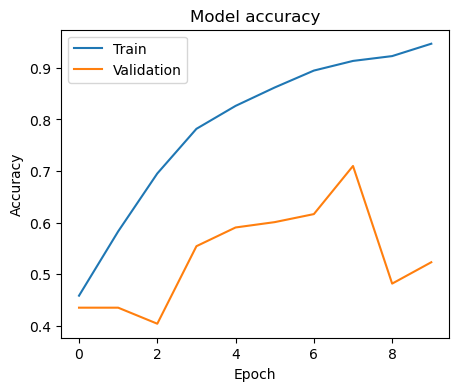

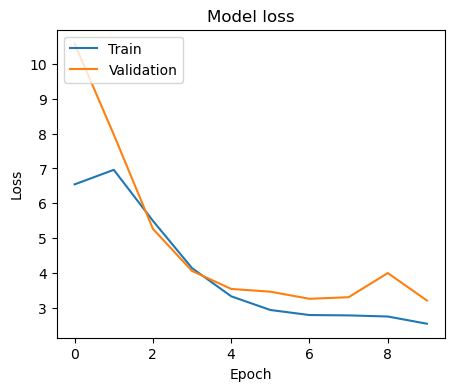

In [9]:
# Your work for building a basic model and then applying improvements
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model = Sequential()
num_classes =4
batch_size =100
epochs = 10

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(225, 225, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.4))  

model.add(Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(units=num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

opt = Adam(learning_rate=0.0008, beta_1=0.9)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

model.fit(train_x_orig, train_y, batch_size=batch_size, epochs=epochs, validation_data=(test_x_orig, test_y), callbacks=[early_stop])

# Train/validation accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Train/validation loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


### 2.3 - Idea, Code, Experiment Cycle

Now go through a iterative process to improve your model. This will involve things like (not an exhaustive list):
- Checking whether you have a bias and/or variance problem. How will you address it? 
- Hyperparameter tuning: learning rate, # of layers, # of hidden units, activation functions, mini-batch size, etc.
- Trying any of the improvements made to the model in part 2.2 to see if it leads to better results

We want to see the progression of your model to a final version with the best results you can achieve. You don't have to show results for every single experiment you tried, but a general progression of different models at various stages of development should be included. Feel free to include discussion, diagrams, tables, and/or graphs that may summarize some of your experiments. **If you only show us the final model you've built, your mark will be minimal**.

Your discussion should also include details on the methodology you used in your experiments. For example, how did you approach hyperparameter tuning?


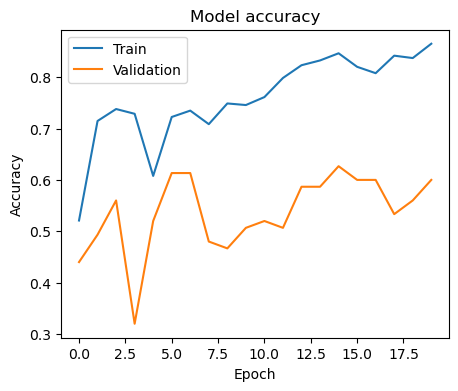

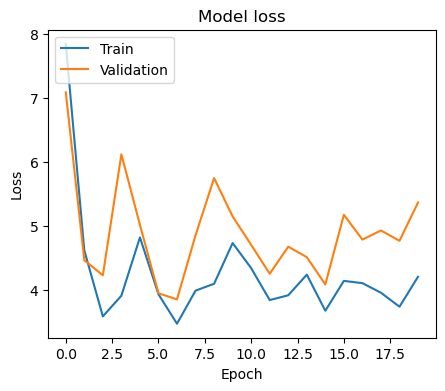

In [52]:
# Your work for building a basic model and then applying improvements
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from keras import regularizers

model = Sequential()
num_classes =4
batch_size =10
epochs = 20

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(225, 225, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(units=num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_x_orig, train_y, batch_size=batch_size, epochs=epochs, validation_data=(test_x_orig, test_y), verbose = 0)

# Train/validation accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Train/validation loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


This result seems to suggest that there is overfitting seems to be happening since the difference betwenn the trining and validation/test is so high, we are already applying regularization so it seems very weird that overfitting is still occuring, this means that I need to get more data right now train data is 645 images and training is 75, lets see what happens whne I increase those numbers.

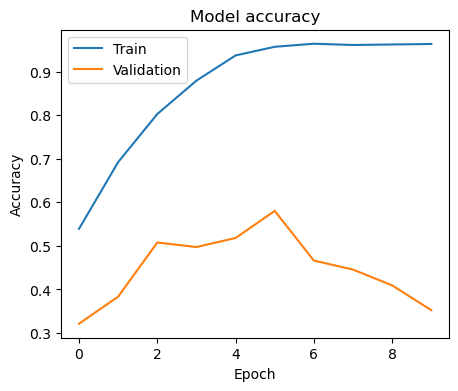

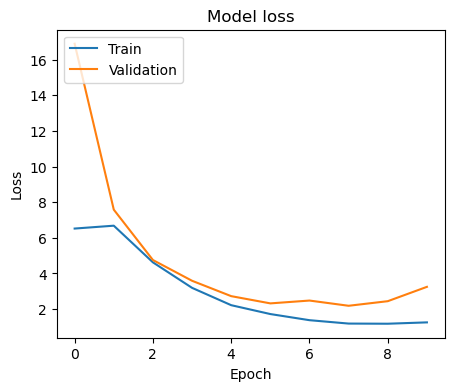

In [63]:
# Your work for building a basic model and then applying improvements
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from keras import regularizers

model = Sequential()
num_classes =4
batch_size =100
epochs = 10

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(225, 225, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(units=num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_x_orig, train_y, batch_size=batch_size, epochs=epochs, validation_data=(test_x_orig, test_y), verbose = 0)

# Train/validation accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Train/validation loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The only changes I made were the batch size and the size of that dataset but this seems to have gotten worse interms of overfitting, since the gap between accracies seems to get bigger cand the loss for test seems to increase by the end, meaning that the fault was in reularization all along now for the next experiment I will try to improve the regularization and see if it makes a difference.

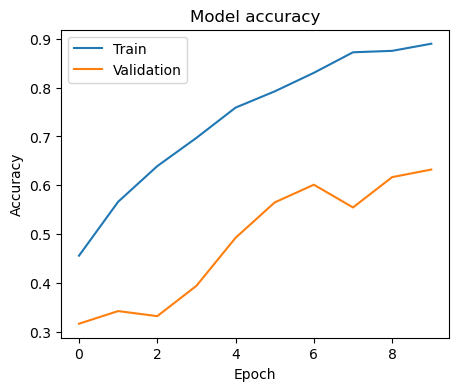

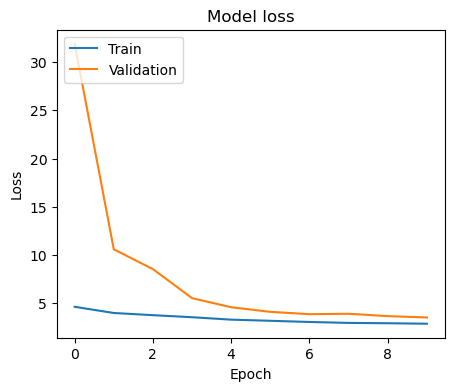

In [82]:
# Your work for building a basic model and then applying improvements
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras import regularizers
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

model = Sequential()
num_classes =4
batch_size =100
epochs = 10

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(225, 225, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))#---removed one convolutional layer
model.add(Flatten())
model.add(Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.7))  # add dropout layer ---new

model.add(Dense(units=num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))
opt = SGD(lr=0.001, momentum=0.9)#---new
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])#---new
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')#---new

model.fit(train_x_orig, train_y, batch_size=batch_size, epochs=epochs, validation_data=(test_x_orig, test_y), callbacks=[early_stop], verbose = 0)#---new

# Train/validation accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Train/validation loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



This time, I carefully analyzed the issue of overfitting and discovered that regularization was not being properly enforced, and that the Adam optimizer was not suitable for my model. To address these issues, I implemented Drop regularization with L2 regularization and changed the optimization algorithm to SGD. Additionally, I added an early stopping mechanism to prevent overfitting, and simplified the model by removing the second convolutional layer. These changes have effectively prevented overfitting, as evidenced by the decreasing test cost and increasing test accuracy, although it is still slightly lower than the train accuracy.

In order to further improve the test accuracy, I plan to experiment with larger neural networks and/or increase the training duration.

Epoch 10: early stopping


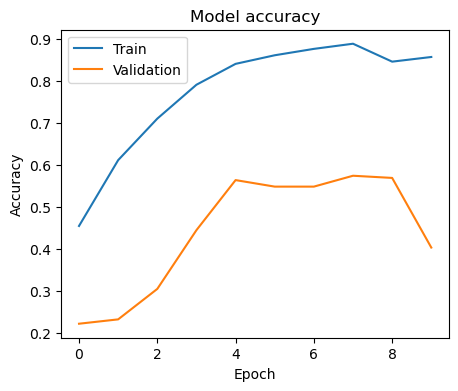

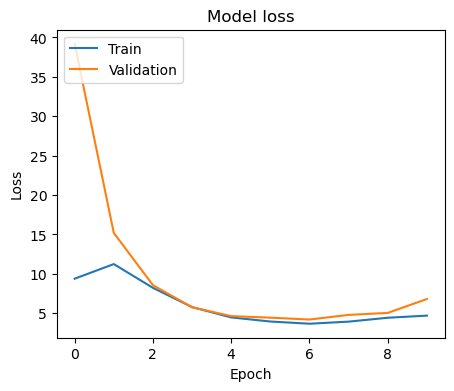

In [121]:
# Your work for building a basic model and then applying improvements
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model = Sequential()
num_classes =4
batch_size =100
epochs = 10

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(225, 225, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.4))  

model.add(Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))#---new layer
model.add(BatchNormalization())
model.add(Dropout(0.1))  

model.add(Dense(units=num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

opt = Adam(learning_rate=0.001)#---new optamizer

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

model.fit(train_x_orig, train_y, batch_size=batch_size, epochs=epochs, validation_data=(test_x_orig, test_y), callbacks=[early_stop], verbose =0)

# Train/validation accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Train/validation loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

I added another layer to the model and replaced the Adam optimizer with SGD in order to increase the accuracy. Although the accuracy did improve slightly, I noticed that the early stopping mechanism stopped the model at epoch 10 due to overfitting, indicating that the regularization was not strict enough. If I can improve the regularization, I believe that the model can achieve even higher test accuracy without overfitting.

In [ ]:
# Your work for building a basic model and then applying improvements
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

model = Sequential()
num_classes =4
batch_size =100
epochs = 10

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(225, 225, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.4))  

model.add(Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(units=32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))#---new added a new layer
model.add(BatchNormalization())
model.add(Dropout(0.2))  

model.add(Dense(units=num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

opt = Adam(learning_rate=0.001, beta_1=0.9)#--new introduced beta_1

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

model.fit(train_x_orig, train_y, batch_size=batch_size, epochs=epochs, validation_data=(test_x_orig, test_y), callbacks=[early_stop])

# Train/validation accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Train/validation loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


After multiple attempts I found that using three layers and having a mild strict dropout on each layer I will be able to increase the accuracy of the model. In the code above I added beta_1 to Adam optamization soo that I can avoid all the local minimas and also I added a new layer 3rd layer with 32 nodes to improve the accuracy. Now even though this method decreased the training accuracy, that is good because now there is no over fitting anf test accuracy is higher than before

**Grading**: 
- Part 1 code for L_layer_model(): **10 marks**
- Part 2:
  - Dataset choice and analysis: **10 marks**
  - Building your model:
    - Basic model: **5 marks**
    - Implementing improvements to model: **15 marks**
  - Idea, Code, Experiment Cycle: **20 marks**

**Total** for project: **60 marks**

**Submission**: Submit a zip file containing all of the files/folders for your project. Make sure all files are included; do not assume we have certain files already.